### *BOLTZ 2 Google Colab Interface*

2025-06-13 by Aarshit Mittal

This notebook provides a simple way to harness the power of [BOLTZ 2](https://github.com/jwohlwend/boltz) (MIT license) for:
- High-accuracy protein structure prediction
- Protein-ligand binding affinity calculation  
- Protein-protein complex modeling
- Mutation impact analysis
- Multi-variant comparison
- Structure quality assessment

---

In [1]:
#@title Install Dependencies (with version check)
import os
import sys

# --- 1. Define required versions ---
# This makes it easy to update versions in the future
REQUIRED_TORCH_VERSION = "2.4.0"
REQUIRED_PL_VERSION = "2.5.0"

# A flag to determine if we need to run the installation
needs_install = False

# --- 2. Check if the correct versions are already installed ---
try:
    import torch
    import pytorch_lightning as pl

    # Check if the installed versions match our requirements.
    # We use .startswith() to ignore suffixes like "+cu118"
    torch_ok = torch.__version__.startswith(REQUIRED_TORCH_VERSION)
    pl_ok = pl.__version__.startswith(REQUIRED_PL_VERSION)

    if torch_ok and pl_ok:
        print(f"✓ Correct versions already installed.")
        print(f"  - PyTorch: {torch.__version__}")
        print(f"  - PyTorch-Lightning: {pl.__version__}")
        print("Skipping installation.")
    else:
        print("Mismatched versions detected. Reinstallation is required.")
        if not torch_ok:
            print(f"  - Found PyTorch {torch.__version__}, but require {REQUIRED_TORCH_VERSION}")
        if not pl_ok:
            print(f"  - Found PyTorch-Lightning {pl.__version__}, but require {REQUIRED_PL_VERSION}")
        needs_install = True

except ImportError:
    # This block runs if one of the libraries isn't installed at all
    print("Required libraries not found. Installation is required.")
    needs_install = True

# --- 3. Run installation and restart ONLY if needed ---
if needs_install:
    print("\nUninstalling existing PyTorch to avoid conflicts...")
    # Using sys.executable ensures we use the correct pip
    !{sys.executable} -m pip uninstall torch torchvision torchaudio -y -q

    print("Installing specified library versions...")
    !{sys.executable} -m pip install torch=={REQUIRED_TORCH_VERSION} torchvision==0.19.0 --index-url https://download.pytorch.org/whl/cu118 -q
    !{sys.executable} -m pip install pytorch-lightning=={REQUIRED_PL_VERSION} boltz py3Dmol -q
    print("Installation complete.")

    # Crucial step: Restart the runtime to load the new libraries
    print("\nIMPORTANT: Runtime is restarting to load new versions. Please wait...")
    os.kill(os.getpid(), 9)

✓ Correct versions already installed.
  - PyTorch: 2.4.0+cu118
  - PyTorch-Lightning: 2.5.0
Skipping installation.


In [2]:
#@title Verify Installation
import torch
import pytorch_lightning as pl
import boltz
import py3Dmol

print("✅ Dependencies loaded successfully!")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ PyTorch-Lightning version: {pl.__version__}")
print(f"✓ BOLTZ installed")
print(f"✓ py3Dmol installed")
print("-" * 30)
print(f"✓ GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'Not available'}")

✅ Dependencies loaded successfully!
✓ PyTorch version: 2.4.0+cu118
✓ PyTorch-Lightning version: 2.5.0
✓ BOLTZ installed
✓ py3Dmol installed
------------------------------
✓ GPU: Tesla T4


In [3]:
#@title Import Libraries
import os
import sys
import subprocess
import json
import tempfile
import yaml
import shutil
from pathlib import Path
import time
from datetime import datetime
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import py3Dmol
from google.colab import files
from IPython.display import display, HTML
import torch

# Configure environment
os.makedirs('output', exist_ok=True)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpu_info = torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU only'
print(f"Device: {device} ({gpu_info})")

Device: cuda (Tesla T4)


In [4]:
#@title Core BOLTZ Interface

class BOLTZPredictor:
    """Main interface for BOLTZ 2 predictions"""

    def __init__(self, output_dir: str = "output"):
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)

    def run_prediction(self, input_data: dict, job_name: str,
                      use_msa: bool = True, verbose: bool = False) -> dict:
        """
        Execute BOLTZ prediction

        Args:
            input_data: YAML-compatible input dictionary
            job_name: Unique identifier for this job
            use_msa: Whether to use MSA server
            verbose: Print detailed output

        Returns:
            Dictionary containing results and file paths
        """
        # Create temporary YAML file
        with tempfile.NamedTemporaryFile(mode='w', suffix='.yaml', delete=False) as f:
            yaml.dump(input_data, f)
            yaml_path = f.name

        # Build command
        output_path = self.output_dir / job_name
        cmd = ["boltz", "predict", yaml_path, "--out_dir", str(output_path)]

        if use_msa:
            cmd.append("--use_msa_server")

        try:
            # Execute prediction
            process = subprocess.Popen(cmd, stdout=subprocess.PIPE,
                                     stderr=subprocess.PIPE, text=True)
            stdout, stderr = process.communicate()

            if process.returncode != 0:
                return {"success": False, "error": stderr or stdout}

            # Parse results
            result_dirs = list(output_path.glob("boltz_results_*"))

            files = {"pdb": [], "cif": [], "json": []}
            for result_dir in result_dirs:
                files["pdb"].extend(list(result_dir.rglob("*.pdb")))
                files["cif"].extend(list(result_dir.rglob("*.cif")))
                files["json"].extend(list(result_dir.rglob("*.json")))

            # Load JSON results
            results = {}
            for json_file in files["json"]:
                try:
                    with open(json_file) as f:
                        results[json_file.name] = json.load(f)
                except Exception as e:
                    if verbose:
                        print(f"Warning: Could not read {json_file.name}: {e}")

            return {
                "success": True,
                "output_dir": str(output_path),
                "files": files,
                "results": results,
                "stdout": stdout if verbose else None
            }

        except Exception as e:
            return {"success": False, "error": str(e)}
        finally:
            Path(yaml_path).unlink(missing_ok=True)

    def extract_metrics(self, results: dict) -> dict:
        """Extract key metrics from BOLTZ results"""
        metrics = {}

        for filename, data in results.items():
            if "confidence" in filename and isinstance(data, dict):
                metrics.update({
                    "confidence_score": data.get("confidence_score", 0),
                    "ptm": data.get("ptm", 0),
                    "iptm": data.get("iptm", 0),
                    "plddt": data.get("complex_plddt", 0)
                })
            elif "affinity" in filename and isinstance(data, dict):
                metrics.update({
                    "affinity_pkd": data.get("affinity_pred_value", 0),
                    "affinity_prob": data.get("affinity_probability_binary", 0)
                })

        return metrics

# Initialize predictor
predictor = BOLTZPredictor()

In [5]:
#@title Visualization Functions

def visualize_structure(structure_path: Path, width: int = 800, height: int = 600):
    """Display 3D molecular structure"""

    with open(structure_path, 'r') as f:
        content = f.read()

    file_format = 'pdb' if str(structure_path).endswith('.pdb') else 'cif'

    view = py3Dmol.view(width=width, height=height)
    view.addModel(content, file_format)
    view.setStyle({'cartoon': {'color': 'spectrum'}})
    view.setBackgroundColor('white')
    view.zoomTo()

    return view

def plot_confidence_distribution(plddt_file: Path) -> plt.Figure:
    """Plot per-residue confidence distribution"""

    data = np.load(plddt_file)
    plddt_values = data['plddt'] * 100  # Convert to percentage

    fig, ax = plt.subplots(figsize=(10, 6))

    # Histogram
    n, bins, patches = ax.hist(plddt_values, bins=50, alpha=0.7,
                               color='#2E86AB', edgecolor='black')

    # Color code by confidence level
    for i, patch in enumerate(patches):
        if bins[i] < 50:
            patch.set_facecolor('#D32F2F')  # Red - Very low
        elif bins[i] < 70:
            patch.set_facecolor('#F57C00')  # Orange - Low
        elif bins[i] < 90:
            patch.set_facecolor('#FBC02D')  # Yellow - Confident
        else:
            patch.set_facecolor('#388E3C')  # Green - High

    ax.axvline(plddt_values.mean(), color='red', linestyle='--', linewidth=2,
               label=f'Mean: {plddt_values.mean():.1f}%')

    ax.set_xlabel('pLDDT Score (%)', fontsize=12)
    ax.set_ylabel('Number of Residues', fontsize=12)
    ax.set_title('Per-Residue Confidence Distribution', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    return fig

In [6]:
#@title 1. Predict Protein Structure

sequence = "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG" #@param {type:"string"}
job_name = "structure_prediction" #@param {type:"string"}
use_msa_server = True #@param {type:"boolean"}

# Validate sequence
valid_aa = set("ACDEFGHIKLMNPQRSTVWY")
sequence = sequence.upper().strip()

if not all(aa in valid_aa for aa in sequence):
    print("Error: Invalid amino acids in sequence")
else:
    # Prepare input
    input_data = {
        "version": 1,
        "sequences": [
            {
                "protein": {
                    "id": "A",
                    "sequence": sequence
                }
            }
        ]
    }

    print(f"Processing sequence: {len(sequence)} residues")
    print(f"Composition: {', '.join([f'{aa}:{sequence.count(aa)}' for aa in sorted(set(sequence))])}")

    # Run prediction
    result = predictor.run_prediction(input_data, job_name, use_msa=use_msa_server)

    if result["success"]:
        metrics = predictor.extract_metrics(result["results"])

        # Display metrics
        print("\nPrediction Metrics:")
        print(f"Confidence Score: {metrics.get('confidence_score', 0):.3f}")
        print(f"pTM: {metrics.get('ptm', 0):.3f}")
        print(f"pLDDT: {metrics.get('plddt', 0):.3f}")

        # Quality assessment
        conf = metrics.get('confidence_score', 0)
        if conf > 0.8:
            quality = "EXCELLENT"
        elif conf > 0.7:
            quality = "GOOD"
        else:
            quality = "MODERATE"
        print(f"\nOverall Quality: {quality}")

        # Visualize structure
        if result["files"]["cif"]:
            view = visualize_structure(result["files"]["cif"][0])
            view.show()  # <-- Fixed: Remove display() wrapper

            # Save structure path
            structure_file = result["files"]["cif"][0]
            print(f"\nStructure saved: {structure_file}")
    else:
        print(f"Prediction failed: {result['error']}")

Processing sequence: 65 residues
Composition: A:5, D:1, E:5, G:5, I:5, K:3, L:7, M:1, N:1, P:2, Q:4, R:7, S:6, T:2, V:8, Y:3

Prediction Metrics:
Confidence Score: 0.943
pTM: 0.917
pLDDT: 0.950

Overall Quality: EXCELLENT


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


Structure saved: output/structure_prediction/boltz_results_tmpxyjgzotm/predictions/tmpxyjgzotm/tmpxyjgzotm_model_0.cif


In [7]:
#@title 2. Predict Protein-Ligand Binding
protein_sequence = "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG" #@param {type:"string"}
ligand_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O" #@param {type:"string"}
job_name = "binding_affinity" #@param {type:"string"}

# Prepare input
input_data = {
    "version": 1,
    "sequences": [
        {
            "protein": {
                "id": "A",
                "sequence": protein_sequence.upper().strip()
            }
        },
        {
            "ligand": {
                "id": "B",
                "smiles": ligand_smiles.strip()
            }
        }
    ],
    "properties": [
        {
            "affinity": {
                "binder": "B"
            }
        }
    ]
}

print(f"Protein: {len(protein_sequence)} residues")
print(f"Ligand: {ligand_smiles}")

# Run prediction
result = predictor.run_prediction(input_data, job_name)

if result["success"]:
    metrics = predictor.extract_metrics(result["results"])

    if "affinity_pkd" in metrics:
        print("\nBinding Affinity Results:")
        print(f"Predicted pKd: {metrics['affinity_pkd']:.2f}")
        print(f"Binding Probability: {metrics['affinity_prob']:.3f}")

        # Convert pKd to Kd
        kd_nm = 10 ** (9 - metrics['affinity_pkd'])
        print(f"Predicted Kd: {kd_nm:.2f} nM")

        # Affinity classification
        if kd_nm < 100:
            affinity_class = "Strong"
        elif kd_nm < 1000:
            affinity_class = "Moderate"
        else:
            affinity_class = "Weak"
        print(f"Affinity Classification: {affinity_class}")

    # Visualize complex
    if result["files"]["cif"]:
        view = visualize_structure(result["files"]["cif"][0])
        view.show()

Protein: 65 residues
Ligand: CC(=O)OC1=CC=CC=C1C(=O)O

Binding Affinity Results:
Predicted pKd: 2.20
Binding Probability: 0.338
Predicted Kd: 6274864.07 nM
Affinity Classification: Weak


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [8]:
#@title 3. Predict Protein Complex

chain_A_sequence = "GIVEQCCTSICSLYQLENYCN" #@param {type:"string"}
chain_B_sequence = "FVNQHLCGSHLVEALYLVCGERGFFYTPKT" #@param {type:"string"}
job_name = "protein_complex" #@param {type:"string"}

# Prepare input
input_data = {
    "version": 1,
    "sequences": [
        {
            "protein": {
                "id": "A",
                "sequence": chain_A_sequence.upper().strip()
            }
        },
        {
            "protein": {
                "id": "B",
                "sequence": chain_B_sequence.upper().strip()
            }
        }
    ]
}

print(f"Chain A: {len(chain_A_sequence)} residues")
print(f"Chain B: {len(chain_B_sequence)} residues")
print(f"Total complex: {len(chain_A_sequence) + len(chain_B_sequence)} residues")

# Run prediction
result = predictor.run_prediction(input_data, job_name)

if result["success"]:
    metrics = predictor.extract_metrics(result["results"])

    print("\nComplex Prediction Metrics:")
    print(f"Confidence Score: {metrics.get('confidence_score', 0):.3f}")
    print(f"pTM: {metrics.get('ptm', 0):.3f}")
    print(f"ipTM: {metrics.get('iptm', 0):.3f}")
    print(f"pLDDT: {metrics.get('plddt', 0):.3f}")

    # Interface quality
    iptm = metrics.get('iptm', 0)
    if iptm > 0.8:
        interface_quality = "High confidence"
    elif iptm > 0.6:
        interface_quality = "Moderate confidence"
    else:
        interface_quality = "Low confidence"
    print(f"\nInterface Quality: {interface_quality}")

    # Visualize
    if result["files"]["cif"]:
        view = visualize_structure(result["files"]["cif"][0])
        view.show()

Chain A: 21 residues
Chain B: 30 residues
Total complex: 51 residues

Complex Prediction Metrics:
Confidence Score: 0.903
pTM: 0.890
ipTM: 0.907
pLDDT: 0.901

Interface Quality: High confidence


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Analyzing mutation: K2A
Location: N-terminal

Structural Impact Analysis:
Wild-type confidence: 0.944
Mutant confidence: 0.933
ΔConfidence: -0.011
ΔpLDDT: -0.012

Predicted Impact: Minor effect


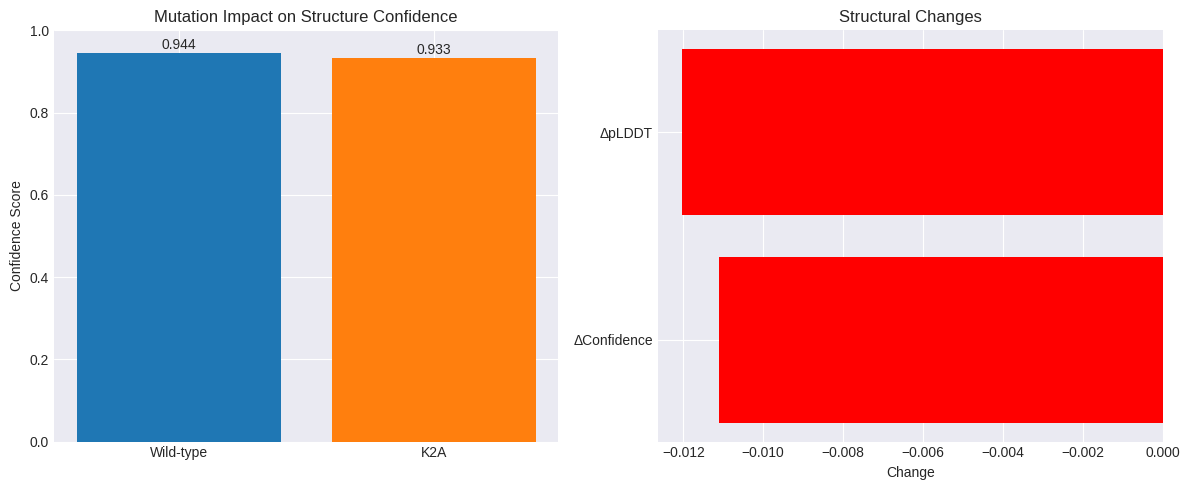

In [9]:
#@title 4. Find Potential Drug Binding Sites
wildtype_sequence = "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG" #@param {type:"string"}
mutation = "K2A" #@param {type:"string"}

def analyze_mutation(wt_seq: str, mutation_str: str) -> dict:
    """
    Analyze the structural impact of a point mutation

    Args:
        wt_seq: Wild-type sequence
        mutation_str: Mutation in format 'X#Y' (e.g., K2A)

    Returns:
        Dictionary with analysis results
    """
    # Parse mutation
    if len(mutation_str) < 3:
        raise ValueError("Invalid mutation format. Use 'X#Y' (e.g., K2A)")

    old_aa = mutation_str[0]
    new_aa = mutation_str[-1]
    position = int(mutation_str[1:-1]) - 1  # Convert to 0-based

    # Validate
    if position >= len(wt_seq) or wt_seq[position] != old_aa:
        print(f"Error: Position {position+1} is {wt_seq[position]}, not {old_aa}")
        return None

    # Create mutant sequence
    mut_seq = list(wt_seq)
    mut_seq[position] = new_aa
    mut_seq = ''.join(mut_seq)

    print(f"Analyzing mutation: {old_aa}{position+1}{new_aa}")
    print(f"Location: {'N-terminal' if position < 20 else 'Core' if position < len(wt_seq)-20 else 'C-terminal'}")

    # Run predictions
    wt_input = {"version": 1, "sequences": [{"protein": {"id": "A", "sequence": wt_seq}}]}
    mut_input = {"version": 1, "sequences": [{"protein": {"id": "A", "sequence": mut_seq}}]}

    wt_result = predictor.run_prediction(wt_input, f"wildtype_{mutation_str}")
    mut_result = predictor.run_prediction(mut_input, f"mutant_{mutation_str}")

    if wt_result["success"] and mut_result["success"]:
        wt_metrics = predictor.extract_metrics(wt_result["results"])
        mut_metrics = predictor.extract_metrics(mut_result["results"])

        # Calculate changes
        delta_conf = mut_metrics.get('confidence_score', 0) - wt_metrics.get('confidence_score', 0)
        delta_plddt = mut_metrics.get('plddt', 0) - wt_metrics.get('plddt', 0)

        # Display results
        print("\nStructural Impact Analysis:")
        print(f"Wild-type confidence: {wt_metrics.get('confidence_score', 0):.3f}")
        print(f"Mutant confidence: {mut_metrics.get('confidence_score', 0):.3f}")
        print(f"ΔConfidence: {delta_conf:+.3f}")
        print(f"ΔpLDDT: {delta_plddt:+.3f}")

        # Interpretation
        if abs(delta_conf) < 0.01:
            impact = "Neutral"
        elif delta_conf < -0.05:
            impact = "Destabilizing"
        elif delta_conf > 0.05:
            impact = "Stabilizing"
        else:
            impact = "Minor effect"

        print(f"\nPredicted Impact: {impact}")

        # Visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Confidence comparison
        variants = ['Wild-type', f'{old_aa}{position+1}{new_aa}']
        confidences = [wt_metrics.get('confidence_score', 0), mut_metrics.get('confidence_score', 0)]

        ax1.bar(variants, confidences, color=['#1f77b4', '#ff7f0e' if delta_conf < 0 else '#2ca02c'])
        ax1.set_ylabel('Confidence Score')
        ax1.set_title('Mutation Impact on Structure Confidence')
        ax1.set_ylim(0, 1)

        for i, v in enumerate(confidences):
            ax1.text(i, v + 0.01, f'{v:.3f}', ha='center')

        # Delta visualization
        ax2.barh(['ΔConfidence', 'ΔpLDDT'], [delta_conf, delta_plddt],
                 color=['red' if delta_conf < 0 else 'green', 'red' if delta_plddt < 0 else 'green'])
        ax2.set_xlabel('Change')
        ax2.set_title('Structural Changes')
        ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

        plt.tight_layout()
        plt.show()

        return {
            'mutation': mutation_str,
            'wt_metrics': wt_metrics,
            'mut_metrics': mut_metrics,
            'delta_confidence': delta_conf,
            'delta_plddt': delta_plddt,
            'impact': impact
        }

    return None

# Run analysis
if wildtype_sequence and mutation:
    analysis = analyze_mutation(wildtype_sequence, mutation)

Comparing 3 variants

Sequence differences from reference:
Variant A: G64A, G65A
Variant B: M1A

Processing Wild-type...

Processing Variant A...

Processing Variant B...


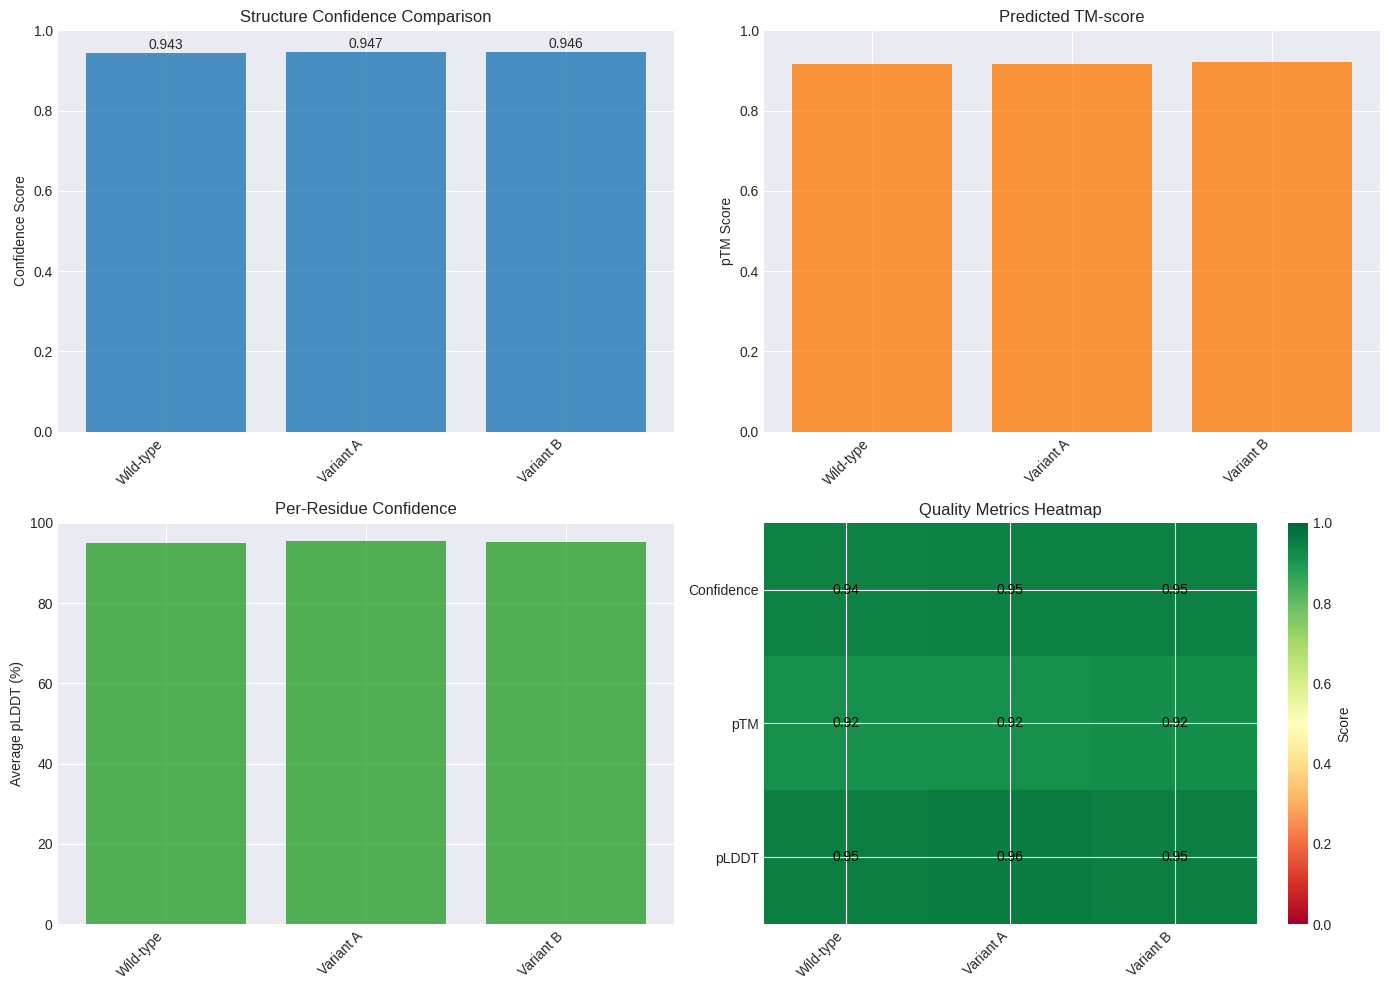


Summary Statistics:
----------------------------------------------------------------------
     name  confidence_score      ptm    plddt
Wild-type          0.943132 0.916006 0.949913
Variant A          0.947168 0.915614 0.955056
Variant B          0.946337 0.921194 0.952623
----------------------------------------------------------------------

Best variant: Variant A (Confidence: 0.947)


In [10]:
#@title 5. Compare Multiple Variants
# Input variants
variant_1_name = "Wild-type" #@param {type:"string"}
variant_1_sequence = "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG" #@param {type:"string"}

variant_2_name = "Variant A" #@param {type:"string"}
variant_2_sequence = "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAAA" #@param {type:"string"}

variant_3_name = "Variant B" #@param {type:"string"}
variant_3_sequence = "AKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG" #@param {type:"string"}

variant_4_name = "" #@param {type:"string"}
variant_4_sequence = "" #@param {type:"string"}

variant_5_name = "" #@param {type:"string"}
variant_5_sequence = "" #@param {type:"string"}

def compare_variants():
    """Compare structural metrics across multiple variants"""

    # Collect variants
    variants = []
    for i in range(1, 6):
        name = globals()[f'variant_{i}_name']
        seq = globals()[f'variant_{i}_sequence']
        if name and seq:
            variants.append((name, seq.upper().strip()))

    if len(variants) < 2:
        print("Error: At least 2 variants required for comparison")
        return None

    print(f"Comparing {len(variants)} variants\n")

    # Sequence analysis
    ref_seq = variants[0][1]
    print("Sequence differences from reference:")
    for name, seq in variants[1:]:
        if len(seq) == len(ref_seq):
            mutations = []
            for pos, (ref_aa, var_aa) in enumerate(zip(ref_seq, seq)):
                if ref_aa != var_aa:
                    mutations.append(f"{ref_aa}{pos+1}{var_aa}")
            print(f"{name}: {', '.join(mutations) if mutations else 'Identical'}")
        else:
            print(f"{name}: Different length ({len(seq)} vs {len(ref_seq)})")

    # Run predictions
    results = []
    for name, seq in variants:
        print(f"\nProcessing {name}...")
        input_data = {"version": 1, "sequences": [{"protein": {"id": "A", "sequence": seq}}]}
        result = predictor.run_prediction(input_data, f"variant_{name.replace(' ', '_')}")

        if result["success"]:
            metrics = predictor.extract_metrics(result["results"])
            metrics['name'] = name
            metrics['length'] = len(seq)
            results.append(metrics)

    if not results:
        print("No successful predictions")
        return None

    # Create comparison DataFrame
    df = pd.DataFrame(results)

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Plot 1: Confidence scores
    ax1 = axes[0, 0]
    x = range(len(df))
    ax1.bar(x, df['confidence_score'], color='#1f77b4', alpha=0.8)
    ax1.set_xticks(x)
    ax1.set_xticklabels(df['name'], rotation=45, ha='right')
    ax1.set_ylabel('Confidence Score')
    ax1.set_title('Structure Confidence Comparison')
    ax1.set_ylim(0, 1)

    for i, v in enumerate(df['confidence_score']):
        ax1.text(i, v + 0.01, f'{v:.3f}', ha='center')

    # Plot 2: pTM scores
    ax2 = axes[0, 1]
    ax2.bar(x, df['ptm'], color='#ff7f0e', alpha=0.8)
    ax2.set_xticks(x)
    ax2.set_xticklabels(df['name'], rotation=45, ha='right')
    ax2.set_ylabel('pTM Score')
    ax2.set_title('Predicted TM-score')
    ax2.set_ylim(0, 1)

    # Plot 3: pLDDT scores
    ax3 = axes[1, 0]
    ax3.bar(x, df['plddt'] * 100, color='#2ca02c', alpha=0.8)
    ax3.set_xticks(x)
    ax3.set_xticklabels(df['name'], rotation=45, ha='right')
    ax3.set_ylabel('Average pLDDT (%)')
    ax3.set_title('Per-Residue Confidence')
    ax3.set_ylim(0, 100)

    # Plot 4: Summary heatmap
    ax4 = axes[1, 1]
    metrics_matrix = df[['confidence_score', 'ptm', 'plddt']].values
    im = ax4.imshow(metrics_matrix.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    ax4.set_yticks(range(3))
    ax4.set_yticklabels(['Confidence', 'pTM', 'pLDDT'])
    ax4.set_xticks(x)
    ax4.set_xticklabels(df['name'], rotation=45, ha='right')
    ax4.set_title('Quality Metrics Heatmap')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax4)
    cbar.set_label('Score')

    # Add values to heatmap
    for i in range(len(df)):
        for j in range(3):
            text = ax4.text(i, j, f'{metrics_matrix[i, j]:.2f}',
                           ha="center", va="center", color="black", fontsize=10)

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\nSummary Statistics:")
    print("-" * 70)
    print(df[['name', 'confidence_score', 'ptm', 'plddt']].to_string(index=False))
    print("-" * 70)

    best_idx = df['confidence_score'].idxmax()
    print(f"\nBest variant: {df.loc[best_idx, 'name']} (Confidence: {df.loc[best_idx, 'confidence_score']:.3f})")

    return df

# Run comparison
comparison_results = compare_variants()

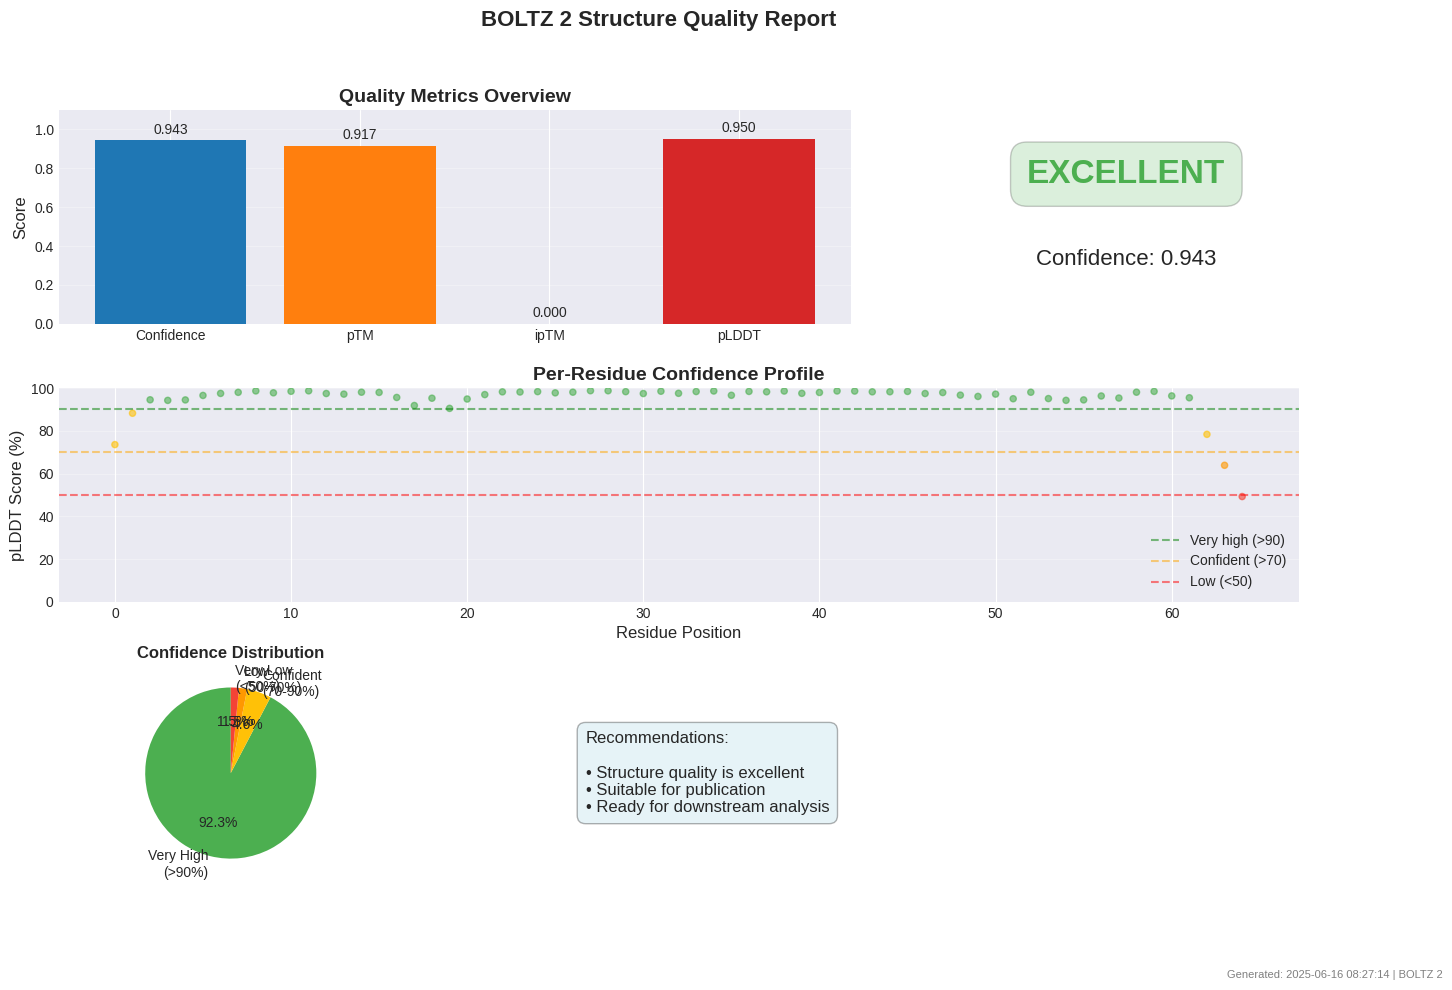


Report saved: output/structure_prediction/boltz_results_tmpxyjgzotm/quality_report_2025-06-16 08-27-14.png


In [11]:
#@title 6. Generate Comprehensive Quality Report

def generate_quality_report(job_name: str = "structure_prediction") -> dict:
    """Generate detailed quality assessment report"""

    output_path = Path(f"output/{job_name}")
    if not output_path.exists():
        print(f"No results found for {job_name}")
        return None

    # Find latest prediction
    result_dirs = sorted(output_path.glob("boltz_results_*"), key=os.path.getmtime, reverse=True)
    if not result_dirs:
        print("No BOLTZ results found")
        return None

    latest_dir = result_dirs[0]

    # Load confidence metrics
    conf_files = list(latest_dir.rglob("confidence_*.json"))
    if not conf_files:
        print("No confidence data found")
        return None

    with open(conf_files[0]) as f:
        confidence_data = json.load(f)

    # Load pLDDT data if available
    plddt_files = list(latest_dir.rglob("plddt_*.npz"))
    plddt_values = None
    if plddt_files:
        plddt_data = np.load(plddt_files[0])
        plddt_values = plddt_data['plddt'] * 100

    # Create comprehensive report
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # 1. Overall metrics
    ax1 = fig.add_subplot(gs[0, :2])
    metrics = {
        'Confidence': confidence_data.get('confidence_score', 0),
        'pTM': confidence_data.get('ptm', 0),
        'ipTM': confidence_data.get('iptm', 0),
        'pLDDT': confidence_data.get('complex_plddt', 0)
    }

    bars = ax1.bar(metrics.keys(), metrics.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax1.set_ylim(0, 1.1)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('Quality Metrics Overview', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)

    for bar, value in zip(bars, metrics.values()):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{value:.3f}', ha='center', va='bottom', fontsize=10)

    # 2. Quality assessment
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.axis('off')

    conf_score = confidence_data.get('confidence_score', 0)
    if conf_score > 0.8:
        quality = "EXCELLENT"
        color = '#4CAF50'
    elif conf_score > 0.7:
        quality = "GOOD"
        color = '#FFC107'
    else:
        quality = "MODERATE"
        color = '#F44336'

    ax2.text(0.5, 0.7, quality, ha='center', va='center', fontsize=24,
             fontweight='bold', color=color,
             bbox=dict(boxstyle="round,pad=0.5", facecolor=color, alpha=0.2))

    ax2.text(0.5, 0.3, f'Confidence: {conf_score:.3f}', ha='center', va='center', fontsize=16)

    # 3. pLDDT distribution
    if plddt_values is not None:
        ax3 = fig.add_subplot(gs[1, :])

        # Per-residue plot
        positions = range(len(plddt_values))
        colors = ['#4CAF50' if v > 90 else '#FFC107' if v > 70 else '#FF9800' if v > 50 else '#F44336'
                  for v in plddt_values]

        ax3.scatter(positions, plddt_values, c=colors, alpha=0.6, s=20)
        ax3.axhline(y=90, color='green', linestyle='--', alpha=0.5, label='Very high (>90)')
        ax3.axhline(y=70, color='orange', linestyle='--', alpha=0.5, label='Confident (>70)')
        ax3.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='Low (<50)')

        ax3.set_xlabel('Residue Position', fontsize=12)
        ax3.set_ylabel('pLDDT Score (%)', fontsize=12)
        ax3.set_title('Per-Residue Confidence Profile', fontsize=14, fontweight='bold')
        ax3.set_ylim(0, 100)
        ax3.legend(loc='lower right')
        ax3.grid(axis='y', alpha=0.3)

    # 4. Confidence regions summary
    ax4 = fig.add_subplot(gs[2, 0])
    if plddt_values is not None:
        regions = {
            'Very High\n(>90%)': np.sum(plddt_values > 90),
            'Confident\n(70-90%)': np.sum((plddt_values >= 70) & (plddt_values <= 90)),
            'Low\n(50-70%)': np.sum((plddt_values >= 50) & (plddt_values < 70)),
            'Very Low\n(<50%)': np.sum(plddt_values < 50)
        }

        colors = ['#4CAF50', '#FFC107', '#FF9800', '#F44336']
        wedges, texts, autotexts = ax4.pie(regions.values(), labels=regions.keys(),
                                           colors=colors, autopct='%1.1f%%',
                                           startangle=90)
        ax4.set_title('Confidence Distribution', fontsize=12, fontweight='bold')

    # 5. Recommendations
    ax5 = fig.add_subplot(gs[2, 1:])
    ax5.axis('off')

    recommendations = []
    if conf_score < 0.8:
        recommendations.append("• Consider increasing recycling steps")
    if plddt_values is not None and np.mean(plddt_values) < 70:
        recommendations.append("• Low average pLDDT - verify sequence")
    if confidence_data.get('iptm', 0) < 0.8 and confidence_data.get('iptm', 0) > 0:
        recommendations.append("• Interface confidence is moderate")

    if not recommendations:
        recommendations = [
            "• Structure quality is excellent",
            "• Suitable for publication",
            "• Ready for downstream analysis"
        ]

    rec_text = "Recommendations:\n\n" + "\n".join(recommendations)
    ax5.text(0.1, 0.5, rec_text, fontsize=12, va='center',
             bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.3))

    # Add metadata
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    fig.text(0.99, 0.01, f'Generated: {timestamp} | BOLTZ 2',
             ha='right', va='bottom', fontsize=8, color='gray')

    plt.suptitle('BOLTZ 2 Structure Quality Report', fontsize=16, fontweight='bold')

    # Save report
    report_path = latest_dir / f"quality_report_{timestamp.replace(':', '-')}.png"
    plt.savefig(report_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    print(f"\nReport saved: {report_path}")

    # Generate methods text
    methods = f"""
METHODS - Structure Prediction

Protein structure prediction was performed using BOLTZ 2,
implemented via Google Colab. The following parameters were used:

- MSA generation: ColabFold MMseqs2 server
- Recycling steps: 3 (default)
- Diffusion sampling steps: 200 (default)
- Hardware: {gpu_info}
- Date: {timestamp}

Quality metrics:
- Confidence score: {conf_score:.3f}
- pTM: {metrics['pTM']:.3f}
- Average pLDDT: {metrics['pLDDT']*100:.1f}%

Structure quality threshold: pLDDT > 90 (very high confidence),
70-90 (confident), 50-70 (low confidence), <50 (very low confidence).
"""

    methods_file = latest_dir / "methods.txt"
    with open(methods_file, 'w') as f:
        f.write(methods)

    return {
        'metrics': metrics,
        'quality': quality,
        'report_path': str(report_path),
        'methods_path': str(methods_file)
    }

# Generate report
report = generate_quality_report()

In [ ]:
#@title 7. Batch Process Multiple Sequences

# Upload CSV file with columns: name, sequence
print("Upload CSV file with columns: 'name' and 'sequence'")
uploaded = files.upload()

if uploaded:
    import pandas as pd

    filename = list(uploaded.keys())[0]
    df = pd.read_csv(filename)

    if 'name' not in df.columns or 'sequence' not in df.columns:
        print("Error: CSV must have 'name' and 'sequence' columns")
    else:
        print(f"Processing {len(df)} sequences\n")

        results = []
        for idx, row in df.iterrows():
            print(f"[{idx+1}/{len(df)}] {row['name']}")

            input_data = {
                "version": 1,
                "sequences": [{"protein": {"id": "A", "sequence": row['sequence']}}]
            }

            result = predictor.run_prediction(input_data, f"batch_{row['name']}")

            if result["success"]:
                metrics = predictor.extract_metrics(result["results"])
                metrics['name'] = row['name']
                metrics['sequence_length'] = len(row['sequence'])
                results.append(metrics)

        # Summary
        if results:
            results_df = pd.DataFrame(results)
            print("\nBatch Processing Summary:")
            print(results_df[['name', 'sequence_length', 'confidence_score', 'ptm', 'plddt']].to_string(index=False))

            # Save results
            results_df.to_csv('batch_results.csv', index=False)
            print("\nResults saved to batch_results.csv")

In [ ]:
#@title Export Results

def export_all_results():
    """Package all results for download"""

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Create archive
    archive_name = f'boltz_results_{timestamp}'
    shutil.make_archive(archive_name, 'zip', 'output')

    print(f"Created archive: {archive_name}.zip")
    print(f"Size: {os.path.getsize(f'{archive_name}.zip') / 1024 / 1024:.1f} MB")

    # Download
    files.download(f'{archive_name}.zip')

    # Summary of contents
    print("\nArchive contents:")
    for root, dirs, files_list in os.walk('output'):
        level = root.replace('output', '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files_list[:5]:  # Show first 5 files
            print(f'{subindent}{file}')
        if len(files_list) > 5:
            print(f'{subindent}... and {len(files_list)-5} more files')

# Export results
export_all_results()

In [14]:
#@title Example Sequences and Structures

# Example protein sequences
EXAMPLE_PROTEINS = {
   "Lysozyme": {
       "sequence": "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG",
       "description": "Small enzyme, 65 AA, good for testing",
       "typical_confidence": 0.94
   },
   "Insulin A chain": {
       "sequence": "GIVEQCCTSICSLYQLENYCN",
       "description": "21 AA peptide hormone, contains disulfides",
       "typical_confidence": 0.85
   },
   "Insulin B chain": {
       "sequence": "FVNQHLCGSHLVEALYLVCGERGFFYTPKT",
       "description": "30 AA peptide, forms complex with A chain",
       "typical_confidence": 0.87
   },
   "GB1 domain": {
       "sequence": "MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE",
       "description": "56 AA, well-studied fold, excellent for benchmarking",
       "typical_confidence": 0.95
   },
   "WW domain": {
       "sequence": "KLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGNSSSG",
       "description": "38 AA, small β-sheet protein",
       "typical_confidence": 0.88
   },
   "Villin headpiece": {
       "sequence": "LSDEDFKAVFGMTRSAFANLPLWKQQNLKKEKGLF",
       "description": "35 AA, fast-folding protein",
       "typical_confidence": 0.91
   }
}

# Example ligands
EXAMPLE_LIGANDS = {
   "Aspirin": {
       "smiles": "CC(=O)OC1=CC=CC=C1C(=O)O",
       "name": "Acetylsalicylic acid",
       "mw": 180.16
   },
   "Caffeine": {
       "smiles": "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",
       "name": "1,3,7-Trimethylxanthine",
       "mw": 194.19
   },
   "Glucose": {
       "smiles": "C(C1C(C(C(C(O1)O)O)O)O)O",
       "name": "D-Glucose",
       "mw": 180.16
   },
   "ATP": {
       "smiles": "C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(=O)(O)OP(=O)(O)O)O)O)N",
       "name": "Adenosine triphosphate",
       "mw": 507.18
   },
   "NADH": {
       "smiles": "C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(O)OCC3C(C(C(O3)N4C=NC5=C(N=CN=C54)N)O)O)O)O",
       "name": "Nicotinamide adenine dinucleotide",
       "mw": 663.43
   },
   "Heme": {
       "smiles": "CC1=C(C2=CC3=C(C(=C(N3)C=C4C(=C(C(=N4)C=C5C(=C(C(=N5)C=C1N2)C)C=C)C)C=C)C)CCC(=O)O)CCC(=O)O)C",
       "name": "Protoporphyrin IX",
       "mw": 563.66
   }
}

# Example mutations for analysis
EXAMPLE_MUTATIONS = {
   "Conservative": ["V10A", "I15L", "L20V", "S25T"],
   "Charge change": ["K5E", "D8K", "R12D", "E18K"],
   "Hydrophobic to polar": ["L10S", "V15T", "I20N", "F25Y"],
   "Proline mutations": ["G10P", "A15P", "S20P", "T25P"],
   "Glycine mutations": ["A10G", "V15G", "L20G", "S25G"]
}

print("EXAMPLE PROTEINS:")
for name, info in EXAMPLE_PROTEINS.items():
   print(f"\n{name}:")
   print(f"  Length: {len(info['sequence'])} AA")
   print(f"  Description: {info['description']}")
   print(f"  Sequence: {info['sequence'][:30]}...")

print("\n\nEXAMPLE LIGANDS:")
for name, info in EXAMPLE_LIGANDS.items():
   print(f"\n{name} ({info['name']}):")
   print(f"  MW: {info['mw']} g/mol")
   print(f"  SMILES: {info['smiles']}")

EXAMPLE PROTEINS:

Lysozyme:
  Length: 65 AA
  Description: Small enzyme, 65 AA, good for testing
  Sequence: MKTVRQERLKSIVRILERSKEPVSGAQLAE...

Insulin A chain:
  Length: 21 AA
  Description: 21 AA peptide hormone, contains disulfides
  Sequence: GIVEQCCTSICSLYQLENYCN...

Insulin B chain:
  Length: 30 AA
  Description: 30 AA peptide, forms complex with A chain
  Sequence: FVNQHLCGSHLVEALYLVCGERGFFYTPKT...

GB1 domain:
  Length: 56 AA
  Description: 56 AA, well-studied fold, excellent for benchmarking
  Sequence: MTYKLILNGKTLKGETTTEAVDAATAEKVF...

WW domain:
  Length: 39 AA
  Description: 38 AA, small β-sheet protein
  Sequence: KLPPGWEKRMSRSSGRVYYFNHITNASQWE...

Villin headpiece:
  Length: 35 AA
  Description: 35 AA, fast-folding protein
  Sequence: LSDEDFKAVFGMTRSAFANLPLWKQQNLKK...


EXAMPLE LIGANDS:

Aspirin (Acetylsalicylic acid):
  MW: 180.16 g/mol
  SMILES: CC(=O)OC1=CC=CC=C1C(=O)O

Caffeine (1,3,7-Trimethylxanthine):
  MW: 194.19 g/mol
  SMILES: CN1C=NC2=C1C(=O)N(C(=O)N2C)C

Glu